# NBA Prediction Models - Midterm Report
## Kevin Yang, Eric Lee, Derek Young

Our main goal is to build prediction models for NBA team performance. As a first step, we will scrape data from `stats.nba.com` and store relevant data in a local `sqlite` database.

On a broad level, we have decided to focus our project on predicting the outcome of a given nba game. On a high level, our approach will involve determining the most important features in determining game outcomes, and then training a supervised machine learning model on these features over many previous games. There should be certain nuances that we should be careful to account for when modeling nba games. One of these is injuries. We need to find some way of determining the effect that an injured player will have on the result of a game.

In this deliverable, we will focus on data collection and understanding the data. We have provided snippets of code to demonstrate some of the work we have done. 

We will first write a simple scraping function to get player game logs.

In [58]:
import requests
import sqlite3
import pandas as pd
import numpy as np
import time
from datetime import datetime 

# Use svg backend for better quality
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

In [ ]:
def get_player_gamelogs(player_id, season):
    """ Given a player id (int or string) and a season (string, ex: 2016-17), returns a (header, log_list) where the
        header represents a key describing the format of a log in log list
    Input:
        player_id (int or string): player ID number
        season (str): season string, ex: 2016-17
    Output:
        (header, log_list): header is a key describing the format of a log in log list
    """
    
    player_url = ("http://stats.nba.com/stats/playergamelog?DateFrom=&DateTo=&LeagueID=00&PlayerID=" 
                  + str(player_id) + "&Season=" + season + "&SeasonType=Regular+Season")
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:39.0) Gecko/20100101 Firefox/39.0'}
    
    # request the URL and parse the JSON
    response = requests.get(player_url, headers = headers)
    response.raise_for_status() # raise exception if invalid response
    response_json = response.json()
    log_list = response_json['resultSets'][0]['rowSet']
    header = response_json['resultSets'][0]['headers']
    
    return (header, log_list)

def convert_to_df(header, log_list):
    """ Given a header and a log_list, where header is a key describing the format of a log in log list and log_list
    contains a list of game logs, convert_to_dataframe returns this data in dataframe form
    Input:
        header (list): list of column labels
        log_list (list): 2D list containing game logs 
    Output:
        (pd.DataFrame): DataFrame containig the given data
    """
    index = np.arange(1, len(log_list) + 1)
    df = pd.DataFrame(index = index, columns = header)
    
    logs = np.array(log_list)
    logs_transpose = logs.T
    
    for i in xrange(len(header)):
        curr_header = header[i]
        df[curr_header] = logs_transpose[i]
    
    return df
    
#jeremy lin
player_id = 202391
season = "2016-17"

(header, plog_list) = get_player_gamelogs(player_id, season) 

player_df = convert_to_df(header, plog_list)

print player_df.head()

Now that we have a function that extracts player game logs, we might be interested in understanding the importance of thhese player statistics as a predictor for team wins or losses. We can create some bar charts comparing player statistics in wins or losses. 

Additionally, instead of treating wins and losses as binary variables, we can also consider the relationship between player statistics and the point differential in any given game.

In [ ]:
def display_player_wl(player_id, season):
    """ Given a player id (int or string) and a season (string, ex: 2016-17), displays graphs comparing the players
    performance in wins and losses
    Input:
        player_id (int or string): player ID number
        season (str): season string, ex: 2016-17
    Output:
        (header, log_list): header is a key describing the format of a log in log list
    """
    
    (headers, log_list) = get_player_gamelogs(player_id, season)
    
    df = convert_to_df(headers, log_list)
    
    # get rows corresponding to wins / losses
    df_w = df[df['WL'] == 'W']
    df_l = df[df['WL'] == 'L']
    
    # get numerical columns
    num_list = ['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB',
                  'AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']
    
    # get numerical columns
    w_num = df_w.loc[:,['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB',
                  'AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']]
    l_num = df_l.loc[:,['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB',
                  'AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']]
    
    w_mean_list = []
    w_std_list = []
    l_mean_list = []
    l_std_list = []
    
    for i in num_list:
        w_float_list = w_num[i].values.astype(float)
        l_float_list = l_num[i].values.astype(float)
        w_mean_list.append(w_float_list.mean())
        l_mean_list.append(l_float_list.mean())
        w_std_list.append(w_float_list.std())
        l_std_list.append(l_float_list.std())
    
    n_groups = 20
    
    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = .35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(index, w_mean_list, bar_width,
                     alpha=opacity,
                     color='b',
                     yerr=w_std_list,
                     error_kw=error_config,
                     label='Wins')

    rects2 = plt.bar(index + bar_width, l_mean_list, bar_width,
                     alpha=opacity,
                     color='r',
                     yerr=l_std_list,
                     error_kw=error_config,
                     label='Losses')


    plt.xlabel('Player Stats')
    plt.ylabel('Values')
    plt.title('Comparing Player Stats in Wins and Losses')
    #plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
    plt.xticks(index + bar_width, num_list)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
# jeremy lin
# player_id = 202391
# season = "2016-17"

#lebron james
player_id = 2544
season = "2015-16"
display_player_wl(player_id, season)

The above graph is especially interesting because it demonstrates that the performance of a player (in this case, Lebron James) in a given game does not necessarily correlate with more wins. For example, on average Lebron gets more rebounds and (slightly) more points in losses. This is likely because in many wins the games might have been blowout games, so then Lebron would have played less. To account for this, we might wish to analyze the distribution of certain stats depending on the final point differential. To find this, we will work on creating a database of game IDs.

While creating this database of game IDs, we are also creating a database of team specific data. The team specific data is important because we suspect that many features that can be extracted from team data would be predictive for game resuls. These team-specific features, along with some player-specfic features, will be used in a supervised learning model to predict the result of an NBA game.

In [37]:
def get_league_gamelogs(season):
    """ Given a season (string, ex: 2016-17), returns a (header, log_list) where the
        header represents a key describing the format of a log in log list
    Input:
        season (str): season string, ex: 2016-17
    Output:
        (header, log_list): header is a key describing the format of a log in log list
    """
    league_log_url = ("http://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&" + 
                  "Direction=DESC&LeagueID=00&PlayerOrTeam=T&Season=" + str(season) + 
                  "&SeasonType=Regular+Season&Sorter=PTS")
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:39.0) Gecko/20100101 Firefox/39.0'}

    # request the URL and parse the JSON
    response = requests.get(league_log_url, headers = headers)
    response.raise_for_status() # raise exception if invalid response
    response_json = response.json()
    log_list = response_json['resultSets'][0]['rowSet']
    header = response_json['resultSets'][0]['headers']
    
    return (header, log_list)

def generate_year_list(start, yrs):
    """ Generate a year list to pass into load_all_gamlogs
    Input:
        start (int): The first year we are interested in loading
        yrs (int): How many years since start that we are including
    Output:
        (List): List of years
    """
    year_list = []
    curr_yr = start
    for i in xrange(yrs):
        nextyr = curr_yr + 1 
        year_list.append(str(curr_yr)+"-"+str(nextyr)[2:])
        curr_yr = nextyr
    return year_list
    
def load_all_gamelogs(conn, start, yrs):
    """ Load nba gamelog data for the past yrs years as a games tables into an SQLite database given in conn
    Input:
        conn (sqlite3.Connection): Connection object corresponding to the database; used to perform SQL commands.
        yrs (int): Number of years to include in table
    Output:
        None
    """
    
    cursor = conn.cursor()
    
    year_list = generate_year_list(start,yrs) #['2010-11', '2011-12', '2012-13', '2013-14', '2015-16', '2016-17']
    
    # clear league_log table
    cursor.execute('drop table if exists league_log')
    
    # create big table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS league_log (
    season_id TEXT, 
    team_id INTEGER,
    team_abbreviation TEXT,
    team_name TEXT,
    game_id INTEGER,
    game_date INTEGER,
    matchup INTEGER,
    wl STRING,
    min INTEGER,
    fgm INTEGER,
    fga INTEGER,
    fg_pct REAL,
    fg3m INTEGER,
    fg3a INTEGER,
    fg3_pct REAL,
    ftm INTEGER,
    fta INTEGER,
    ft_pct REAL,
    oreb INTEGER,
    dreb INTEGER,
    reb INTEGER,
    ast INTEGER,
    stl INTEGER,
    blk INTEGER,
    tov INTEGER,
    pf INTEGER,
    pts INTEGER,
    plus_minus INTEGER
    )""")
    
    for year in year_list:
        (header, log_list) = get_league_gamelogs(year)
        
        question_marks = "(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
        query_string = "INSERT INTO league_log VALUES " + question_marks
        for log in log_list:
            cursor.execute(query_string,
                          (log[0],log[1],log[2],log[3],log[4],log[5],log[6],log[7],
                          log[8], log[9], log[10], log[11], log[12], log[13], log[14],
                          log[15],log[16], log[17], log[18], log[19], log[20], log[21],
                          log[22], log[23], log[24], log[25], log[26], log[27]))
            
    conn.commit()

In [39]:
conn = sqlite3.connect(r"db/league.db")
conn.text_factory = str

start_year = 1946
length = 2017 - start_year

# TEST SET WILL BE SEASON 2015-16 + 2016-17??
# WHAT SHOULD TRAINING SET AND VALIDATION SET BE?

print generate_year_list(start_year,length)
load_all_gamelogs(conn, start_year, length )

['1946-47', '1947-48', '1948-49', '1949-50', '1950-51', '1951-52', '1952-53', '1953-54', '1954-55', '1955-56', '1956-57', '1957-58', '1958-59', '1959-60', '1960-61', '1961-62', '1962-63', '1963-64', '1964-65', '1965-66', '1966-67', '1967-68', '1968-69', '1969-70', '1970-71', '1971-72', '1972-73', '1973-74', '1974-75', '1975-76', '1976-77', '1977-78', '1978-79', '1979-80', '1980-81', '1981-82', '1982-83', '1983-84', '1984-85', '1985-86', '1986-87', '1987-88', '1988-89', '1989-90', '1990-91', '1991-92', '1992-93', '1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17']


In [40]:
league_df = pd.read_sql_query('SELECT * FROM league_log', conn)
print len(league_df)
league_df.head()

113760


,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus
0,21946,1610610025,CHS,Chicago Stags,24600208,1947-02-06,CHS vs. PIT,W,0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,109,24
1,21946,1610610025,CHS,Chicago Stags,24600284,1947-03-09,CHS @ CLR,W,0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,107,30
2,21946,1610610025,CHS,Chicago Stags,24600280,1947-03-08,CHS vs. PRO,W,0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,107,26
3,21946,1610610036,WAS,Washington Capitols,24600199,1947-02-02,WAS @ CLR,W,0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,107,26
4,21946,1610610036,WAS,Washington Capitols,24600320,1947-03-26,WAS vs. CHS,W,0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,105,28


We have now loaded some league game logs into our database `league.db`. We can now write some data validation functions for our data, as we might be missing certain games.

In [ ]:
def validate_data(df):
    year_list = df['season_id'].unique().tolist()
    
    for year in year_list:
        df_temp = df[df['season_id'] == year]
        
        if year == '22011':
            # lockout year
            assert(df_temp.shape[0] == 1980)
        elif year == '22016':
            # current ongoing year
            continue
        else:
            #normal 82 game sched
            assert(df_temp.shape[0] == 2460) 
        
validate_data(league_df)

## Preprocessing and Understanding the Data
Now that we have stored key data points on each game, we wish to process the data to describe key features of our data, and then better understand these features through analyses and visualizations.

We first want to create a large league df with extra features, including the following:
1. Home W/L Percentage
2. Away W/L Percentage
3. Home Average Point Differential
4. Away Average Point Differential
5. Home W/L Percentage in Previous 8 Games
6. Away W/L Percentage in Previous 8 Games
7. Away W/L Percentage as Away Team
8. Home W/L Percentage as Home Team
9. Indicator whether the team is on a back-to-back

In [41]:
def preprocess(league_df):
    """ Given a dataframe league_df, returns new league_df by converting the 'game_date' column to datetime if 
    necessary, and adds is_home indicator and opp_team_id indicator
    Input:
        df (pandas.DataFrame): dataframe containing league logs
    Output:
        pandas.DataFrame
    """
    # convert to datetime, note this is in place!
    league_df['game_date'] = league_df['game_date'].apply(pd.to_datetime)
    
    # add new columns
    is_home = np.zeros(len(league_df), dtype=np.int64)
    opp_team_id = np.zeros(len(league_df), dtype=np.int64)
    wl_binary = np.zeros(len(league_df), dtype = np.int64)
    
    league_df = league_df.assign(is_home = is_home)
    league_df = league_df.assign(opp_team_id = opp_team_id)
    league_df = league_df.assign(wl_binary = wl_binary)
    
    # add home indicator variable
    for (index, row) in league_df.iterrows():
        matchup = row['matchup']
        if "@" in matchup:
            league_df.set_value(index, "is_home", 0)
        else:
            league_df.set_value(index, "is_home", 1)
            
    # add opposing team ID
    for (index,row) in league_df.iterrows():
        game_id = row['game_id']
        team_id = row['team_id']
        
        # find other game with the same game ID
        df_game = league_df[league_df['game_id'] == game_id]
        assert(len(df_game) == 2)
        found_opp = False
        for (inner_index,inner_row) in df_game.iterrows():
            curr_team_id = inner_row['team_id']
            if curr_team_id == team_id:
                continue
            else:
                # found opposing team, update opposing team ID
                league_df.set_value(index, 'opp_team_id', curr_team_id)
                found_opp = True
        assert(found_opp)
        
    # add binary representation of wins and losses
    for (index, row) in league_df.iterrows():
        wl = row['wl']
        if wl == 'W':
            league_df.set_value(index, 'wl_binary', 1)
        else:
            league_df.set_value(index, 'wl_binary', 0)
            
    return league_df
league_df = preprocess(league_df)
league_df.head(10)

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,ast,stl,blk,tov,pf,pts,plus_minus,is_home,opp_team_id,wl_binary
0,21946,1610610025,CHS,Chicago Stags,24600208,1947-02-06,CHS vs. PIT,W,0,48.0,...,NaN,NaN,NaN,NaN,28.0,109,24,1,1610610031,1
1,21946,1610610025,CHS,Chicago Stags,24600284,1947-03-09,CHS @ CLR,W,0,36.0,...,NaN,NaN,NaN,NaN,27.0,107,30,0,1610610026,1
2,21946,1610610025,CHS,Chicago Stags,24600280,1947-03-08,CHS vs. PRO,W,0,43.0,...,NaN,NaN,NaN,NaN,33.0,107,26,1,1610610032,1
3,21946,1610610036,WAS,Washington Capitols,24600199,1947-02-02,WAS @ CLR,W,0,43.0,...,NaN,NaN,NaN,NaN,15.0,107,26,0,1610610026,1
4,21946,1610610036,WAS,Washington Capitols,24600320,1947-03-26,WAS vs. CHS,W,0,42.0,...,NaN,NaN,NaN,NaN,16.0,105,28,1,1610610025,1
5,21946,1610612744,PHW,Philadelphia Warriors,24600157,1947-01-14,PHW @ HUS,W,0,44.0,...,NaN,NaN,NaN,NaN,NaN,104,30,0,1610610035,1
6,21946,1610612744,PHW,Philadelphia Warriors,24600310,1947-03-22,PHW @ PRO,W,0,35.0,...,NaN,NaN,NaN,NaN,NaN,103,21,0,1610610032,1
7,21946,1610610034,BOM,St. Louis Bombers,24600129,1947-01-01,BOM @ CHS,W,0,39.0,...,NaN,NaN,NaN,NaN,29.0,103,13,0,1610610025,1
8,21946,1610610025,CHS,Chicago Stags,24600221,1947-02-12,CHS @ PIT,W,0,40.0,...,NaN,NaN,NaN,NaN,NaN,101,19,0,1610610031,1
9,21946,1610610025,CHS,Chicago Stags,24600309,1947-03-21,CHS @ HUS,W,0,43.0,...,NaN,NaN,NaN,NaN,24.0,99,16,0,1610610035,1


In [ ]:
new_df1 = league_df.sort_values('game_date')
new_df1[new_df1["team_abbreviation"] == "DAL"].head()

In [42]:
def add_extra_features(league_df):
    """ Given a dataframe league_df, returns a new df containing extra columns for each new feature
    Input:
        df (pandas.DataFrame): dataframe containing league logs
    Output:
        pd.DataFrame
    """
    
    lookback = 8

    #print league_df['game_date'].dtype
    
    #converted_row = pd.to_datetime(league_df['game_date'])
    #print league_df['game_date'].dtype
    
    new_df = league_df.sort_values('game_date')
    
    # add new columns
    home_win_pct = np.zeros(len(new_df))
    away_win_pct = np.zeros(len(new_df))
    home_avg_pt_diff = np.zeros(len(new_df))
    away_avg_pt_diff = np.zeros(len(new_df))
    home_win_pct_N = np.zeros(len(new_df))
    away_win_pct_N = np.zeros(len(new_df))
    away_win_pct_as_away = np.zeros(len(new_df))
    home_win_pct_as_home = np.zeros(len(new_df))
    home_back_to_back = np.zeros(len(new_df))
    away_back_to_back = np.zeros(len(new_df))
    home_game_count = np.zeros(len(new_df))
    away_game_count = np.zeros(len(new_df))
    
    new_df = new_df.assign(home_win_pct = home_win_pct)
    new_df = new_df.assign(away_win_pct = away_win_pct)
    new_df = new_df.assign(home_avg_pt_diff = home_avg_pt_diff)
    new_df = new_df.assign(away_avg_pt_diff = away_avg_pt_diff)
    new_df = new_df.assign(home_win_pct_N = home_win_pct_N)
    new_df = new_df.assign(away_win_pct_N = away_win_pct_N)
    new_df = new_df.assign(away_win_pct_as_away = away_win_pct_as_away)
    new_df = new_df.assign(home_win_pct_as_home = home_win_pct_as_home)
    new_df = new_df.assign(home_back_to_back = home_back_to_back)
    new_df = new_df.assign(away_back_to_back = away_back_to_back)
    new_df = new_df.assign(home_game_count = home_game_count)
    new_df = new_df.assign(away_game_count = away_game_count)
    
    # add features
    grouped = new_df.groupby(['season_id'])
    groupList = [grouped.get_group(x) for x in grouped.groups]
    
    for season_df in groupList:
        # initialize dictionary containing wins and losses for each team
        win_dict = dict()
        lose_dict = dict()
        running_dict = dict()
        
        # stores list of game dates for each team
        running_date_dict = dict()
        
        # total plus minus so far
        plus_minus_dict = dict()
        
        # stores home and away game counts and w/l counts
        wins_as_home = dict()
        wins_as_away = dict()
        games_as_home = dict()
        games_as_away = dict()
        
        for team in season_df['team_id'].unique():
            win_dict[team] = 0
            lose_dict[team] = 0
            running_dict[team] = []
            plus_minus_dict[team] = 0
            running_date_dict[team] = []
            
            # track wins at home, at away, and total games at home, at away
            wins_as_home[team] = 0
            wins_as_away[team] = 0
            games_as_home[team] = 0
            games_as_away[team] = 0
        
        # sort season by day
        season_df = season_df.sort_values('game_date')
        
        seen_games = set()
        
        for (index, row) in season_df.iterrows():
            is_home = row['is_home']
            team_id = row['team_id']
            opp_team_id = row['opp_team_id']
            wl = row['wl']
            game_id = row['game_id']
            curr_team_plus_minus = row['plus_minus']
            opp_team_plus_minus = -curr_team_plus_minus
            game_date = row['game_date']
            
            if is_home == 1:
                home_team_id = team_id
                away_team_id = opp_team_id
            else:
                home_team_id = opp_team_id
                away_team_id = team_id

            home_win_pct = 0
            away_win_pct = 0

            if win_dict[home_team_id] + lose_dict[home_team_id] > 0:
                home_win_pct = (win_dict[home_team_id])/float(win_dict[home_team_id] + lose_dict[home_team_id])
            if win_dict[away_team_id] + lose_dict[away_team_id] > 0:
                away_win_pct = (win_dict[away_team_id])/float(win_dict[away_team_id] + lose_dict[away_team_id])
                
            new_df.set_value(index, 'home_win_pct', home_win_pct)
            new_df.set_value(index, 'away_win_pct', away_win_pct)

            home_win_pct_N = 0
            away_win_pct_N = 0
            
            home_games_count = len(running_dict[home_team_id])
            away_games_count = len(running_dict[away_team_id])
            
            new_df.set_value(index, 'home_game_count', home_games_count)
            new_df.set_value(index, 'away_game_count', away_games_count)
            
            if home_games_count > 0:
                if home_games_count > lookback:
                    lookback_games = running_dict[home_team_id][home_games_count - lookback:]
                else:
                    lookback_games = running_dict[home_team_id]
                home_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            if away_games_count > 0:
                if away_games_count > lookback:
                    lookback_games = running_dict[away_team_id][away_games_count - lookback:]
                else:
                    lookback_games = running_dict[away_team_id]
                away_win_pct_N = sum(lookback_games)/float(len(lookback_games))
                
            new_df.set_value(index, 'home_win_pct_N', home_win_pct_N)
            new_df.set_value(index, 'away_win_pct_N', away_win_pct_N)
                
            home_avg_pt_diff = 0
            away_avg_pt_diff = 0
            
            if home_games_count > 0:
                running_pt_diff = plus_minus_dict[home_team_id]
                home_avg_pt_diff = running_pt_diff/float(home_games_count)
            if away_games_count > 0:
                running_pt_diff = plus_minus_dict[away_team_id]
                away_avg_pt_diff = running_pt_diff/float(away_games_count)
                
            new_df.set_value(index, 'home_avg_pt_diff', home_avg_pt_diff)
            new_df.set_value(index, 'away_avg_pt_diff', away_avg_pt_diff)
                
            home_back_to_back = 0
            away_back_to_back = 0
            
            if home_games_count > 0:
                most_recent_date = running_date_dict[home_team_id][home_games_count - 1]
                #most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
                #curr_date = datetime.strptime(game_date, "%Y-%m-%d")
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # back to back
                    home_back_to_back = 1
                
            if away_games_count > 0:
                most_recent_date = running_date_dict[away_team_id][away_games_count - 1]
                #most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
                #curr_date = datetime.strptime(game_date, "%Y-%m-%d")
                
                if game_date.toordinal() - most_recent_date.toordinal() == 1:
                    # back to back
                    away_back_to_back = 1
                    
            new_df.set_value(index, 'home_back_to_back', home_back_to_back)
            new_df.set_value(index, 'away_back_to_back', away_back_to_back)
            
            #update home_win_pct_as_home, away_win_pct_as_away
            home_win_pct_as_home = 0
            away_win_pct_as_away = 0
            
            home_games_as_home = games_as_home[home_team_id]
            away_games_as_away = games_as_away[away_team_id]
            
            if (home_games_as_home > 0):
                home_win_pct_as_home = (wins_as_home[home_team_id])/float(home_games_as_home)
            if (away_games_as_away > 0):
                away_win_pct_as_away = (wins_as_away[away_team_id])/float(away_games_as_away)
                
            new_df.set_value(index, 'home_win_pct_as_home', home_win_pct_as_home)
            new_df.set_value(index, 'away_win_pct_as_away', away_win_pct_as_away)
            
            # update running stats
            if (wl == 'W'):
                if game_id in seen_games:
                    win_dict[team_id] += 1
                    lose_dict[opp_team_id] += 1
                    running_dict[team_id].append(1)
                    running_dict[opp_team_id].append(0)
                    
                    # update home team and away team w/l
                    if is_home == 1:
                        wins_as_home[team_id] += 1
                        games_as_home[team_id] += 1
                        games_as_away[opp_team_id] += 1
                    else:
                        wins_as_away[team_id] += 1
                        games_as_away[team_id] += 1
                        games_as_home[opp_team_id] += 1
                    
            else:
                if game_id in seen_games:
                    win_dict[opp_team_id] += 1
                    lose_dict[team_id] += 1
                    running_dict[opp_team_id].append(1)
                    running_dict[team_id].append(0)
                    
                    # update home team and away team w/l
                    if is_home == 1:
                        wins_as_away[opp_team_id] += 1
                        games_as_away[opp_team_id] += 1
                        games_as_home[team_id] += 1
                        
                    else:
                        wins_as_home[opp_team_id] += 1
                        games_as_home[opp_team_id] += 1
                        games_as_away[team_id] += 1
            if game_id in seen_games:
                plus_minus_dict[team_id] += curr_team_plus_minus
                plus_minus_dict[opp_team_id] += opp_team_plus_minus
                running_date_dict[team_id].append(game_date)
                running_date_dict[opp_team_id].append(game_date)
                
            seen_games.add(game_id)
    return new_df

In [43]:
cutoff = 0
new_df = add_extra_features(league_df)
# all games contains away games and home games, without any cutoff
all_games = new_df
home_games = new_df[new_df['is_home'] == 1]
home_games_with_cutoff = home_games[home_games['home_game_count'] >= cutoff]
home_games_with_cutoff.head(20)
#print home_games_with_cutoff["home_win_pct_as_home"]
#pd.DataFrame.to_csv(home_games_with_cutoff, 'home_games_with_cutoff.csv')


,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,fgm,...,home_avg_pt_diff,away_avg_pt_diff,home_win_pct_N,away_win_pct_N,away_win_pct_as_away,home_win_pct_as_home,home_back_to_back,away_back_to_back,home_game_count,away_game_count
368,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01,HUS vs. NYK,L,0,25.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
661,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02,DEF vs. WAS,L,0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
515,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02,PRO vs. BOS,W,0,21.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
439,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02,CHS vs. NYK,W,0,21.0,...,0.000000,2.000000,0.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,1.0
556,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02,BOM vs. PIT,W,0,20.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
257,21946,1610610026,CLR,Cleveland Rebels,24600006,1946-11-03,CLR vs. HUS,W,0,24.0,...,0.000000,-2.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
555,21946,1610610031,PIT,Pittsburgh Ironmen,24600007,1946-11-04,PIT vs. WAS,L,0,19.0,...,-5.000000,17.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0
570,21946,1610612738,BOS,Boston Celtics,24600008,1946-11-05,BOS vs. CHS,L,0,23.0,...,-6.000000,16.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,1.0,1.0
625,21946,1610610028,DEF,Detroit Falcons,24600009,1946-11-05,DEF vs. BOM,L,0,18.0,...,-17.000000,5.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,1.0,1.0
216,21946,1610610032,PRO,Providence Steamrollers,24600011,1946-11-07,PRO vs. CHS,W,0,31.0,...,6.000000,9.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,1.0,2.0


In [ ]:
pd.DataFrame.to_csv(home_games_with_cutoff, 'home_games_with_cutoff.csv')

In [23]:
#print home_games_with_cutoff["team_abbreviation"].head(n=100)
#print home_games_with_cutoff["home_win_pct"].head(n=100)
#print home_games_with_cutoff["away_win_pct"].head(n=100)

newdf = home_games_with_cutoff[(home_games_with_cutoff["team_abbreviation"] =="DAL")]
#print newdf["home_win_pct"].head()
#print newdf["away_win_pct"].head()
#print newdf.head(n=20)


In [ ]:
def add_point_diff(league_df, player_id, season):
    """ Given a dataframe df, player id (int or string) and a season (string, ex: 2016-17), 
        returns a player log list df containing a new column pt_diff
    Input:
        df (pandas.DataFrame): dataframe containing league logs
        player_id (int or string): player ID number
        season (str): season string, ex: 2016-17
    Output:
        pd.DataFrame
    """
    
    (headers, log_list) = get_player_gamelogs(player_id, season)
    
    df = convert_to_df(headers, log_list)
    
    # point_differentials
    pt_diff = []
    
    for (index, row) in df.iterrows():
        wl = row['WL']
        game_id = int(row['Game_ID'])
        
        # there should be exactly one game with these properties
        single_game_df = league_df[(league_df['game_id'] == game_id) & (league_df['wl'] == wl)]
    
        assert(len(single_game_df) == 1)
        curr_pt_diff = single_game_df['plus_minus'].values[0]
        pt_diff.append(curr_pt_diff)
        
    new_df = df.assign(pt_diff = np.array(pt_diff))
    
    return new_df
        
def graph_point_diff(league_df, player_id, season):
    """ Given a dataframe df, player id (int or string) and a season (string, ex: 2016-17), 
        displays scatter plots comparing the players performance to resulting point differential
    Input:
        league_df (pandas.DataFrame): dataframe containing league logs
        player_id (int or string): player ID number
        season (str): season string, ex: 2016-17
    Output:
        None
    """
    
    new_df = add_point_diff(league_df, player_id, season)
    
    rows, cols = 4, 4
    
    f, axarr = plt.subplots(rows, cols)
    plt.tight_layout()
    
    # get numerical columns
    num_list = ['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB',
                  'AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']
    
    for i in xrange(rows):
        for j in xrange(cols):
            index = i*rows + j
            
            if index > 19:
                continue
            
            curr_col = num_list[index]
            y_array = np.array(new_df[curr_col].astype(float).values)
            x_array = np.array(new_df['pt_diff'].astype(float).values)
                
            axarr[i,j].scatter(x_array, y_array)
            axarr[i,j].title.set_text(curr_col)
                
# example jeremy lin
# player_id = 202391
# season = "2016-17"
# team_id = 1610612751
    
#lebron james
player_id = 2544
season = "2015-16"

#new_df = 
graph_point_diff(league_df, player_id, season)

#new_df.head()



# Injury Analysis
Since injuries have a huge impact on the result of games, we would like our model to account for player injuries. For now, we will do some exploratory analysis to determine the impact a player's injury has on team performance. We will create dataframes for team's games that played the player and those that didn't, and then create a graph showing the difference in team performance.

In [ ]:
def get_player_missedGames(player_id,team, yr, game_log, season):
    """ Given a player id (int or string) and a season (string, ex: 2016-17), returns a (header, log_list) where the
        header represents a key describing the format of a log in log list
    Input:
        player_id (int or string): player ID number
        team (int): team_id number
        yr (str): season string, ex: 2016-17
        game_log (pd.DataFrame): Game_log
        season (str): season_id 
    Output:
        (DataFrame): a DataFrame of all games missed by a particular player in a particular season
    """
    games_missed = pd.DataFrame(columns=('game_id',"team"))
    
    (header, plog_list) = get_player_gamelogs(player_id, yr) 
    player_df = convert_to_df(header, plog_list)
    df = game_log.loc[game_log['season_id'] == season]
    df = df.loc[df['team_id'] == team]
    other_df = df.copy()
    #now have dataframe of all games for a particular team in a particular season
    i = 0
    game_list = []
    for index, row in df.iterrows():
        game = row['game_id']
        if game in list(player_df.ix[:,2].astype(int)): # he did play in this game
            df = df[df.game_id != game]
            game_list.append(game)
    
    # return games that the player did not play in
    other_df = other_df[other_df['game_id'].isin(game_list)]
            
    return df, other_df

# example jeremy lin
player_id = 202391
season = "2016-17"
team_id = 1610612751

(missed_player_df, with_player_df) = get_player_missedGames(player_id,team_id,"2016-17",league_df,"22016")
#(header, plog_list) = get_player_gamelogs(player_id, season) 

#player_df = convert_to_df(header, plog_list)

# get numerical columns
num_list = ['min','fgm','fga','fg_pct','fg3m','fg3a','fg3_pct','ftm','fta','ft_pct','oreb','dreb','reb',
              'ast','stl','blk','tov','pf','pts','plus_minus']

# get numerical columns
w_num = with_player_df.loc[:,num_list]
l_num = missed_player_df.loc[:,num_list]

w_mean_list = []
w_std_list = []
l_mean_list = []
l_std_list = []

for i in num_list:
    w_float_list = w_num[i].values.astype(float)
    l_float_list = l_num[i].values.astype(float)
    w_mean_list.append(w_float_list.mean())
    l_mean_list.append(l_float_list.mean())
    w_std_list.append(w_float_list.std())
    l_std_list.append(l_float_list.std())

n_groups = 20

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = .35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, w_mean_list, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=w_std_list,
                 error_kw=error_config,
                 label='With Player')

rects2 = plt.bar(index + bar_width, l_mean_list, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=l_std_list,
                 error_kw=error_config,
                 label='Without Player')


plt.xlabel('Team Stats')
plt.ylabel('Values')
plt.title('Comparing Player Stats in Wins and Losses')
#plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
plt.xticks(index + bar_width, num_list)
plt.legend()

plt.tight_layout()
plt.show()

# now, compare the two

## Additional Exploratory Graphs

### Finding the cutoff value
At the beginning of every season, there is volatility in terms of the change in win-loss percentage. 

['22004' '22005' '22006' '22007' '22008' '22009' '22010' '22011' '22012'
 '22013' '22014' '22015' '22016']
     season_id     team_id team_abbreviation           team_name   game_id  \
532      22004  1610612742               DAL    Dallas Mavericks  20400002   
1878     22004  1610612747               LAL  Los Angeles Lakers  20400003   
1994     22004  1610612765               DET     Detroit Pistons  20400001   
1603     22004  1610612753               ORL       Orlando Magic  20400005   
281      22004  1610612756               PHX        Phoenix Suns  20400013   

      game_date      matchup wl  min  fgm       ...         home_avg_pt_diff  \
532  2004-11-02  DAL vs. SAC  W  240   40       ...                      0.0   
1878 2004-11-02  LAL vs. DEN  W  240   30       ...                      0.0   
1994 2004-11-02  DET vs. HOU  W  240   32       ...                      0.0   
1603 2004-11-03  ORL vs. MIL  W  240   41       ...                      0.0   
281  2004-11-03  PHX vs.

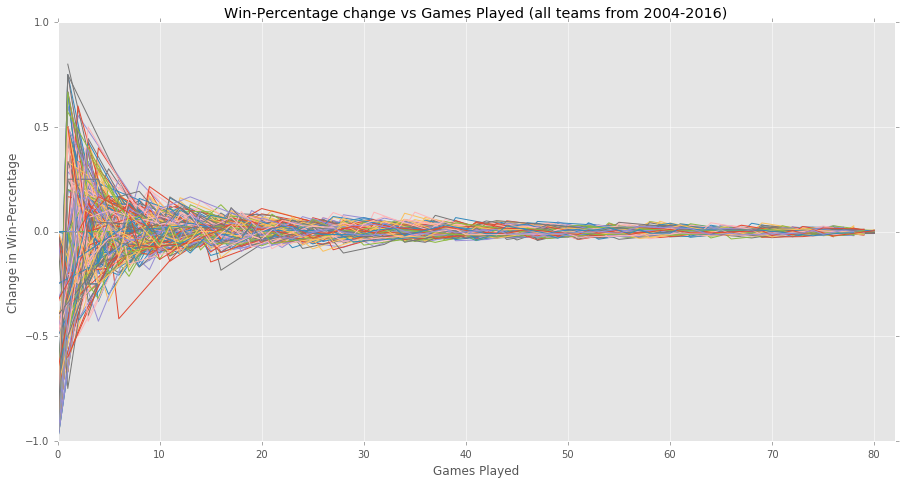

In [24]:
## Graph Win-loss against number of games

all_years_id = home_games_with_cutoff["season_id"].unique()
print all_years_id
print home_games_with_cutoff.head()
print list(home_games_with_cutoff.columns.values)
for year in all_years_id:
    curr_year = home_games_with_cutoff[(home_games_with_cutoff["season_id"] ==year)]
    all_teams = curr_year["team_abbreviation"].unique()
    for team in all_teams:
        newdf = curr_year[(curr_year["team_abbreviation"] ==team)]
        temp = newdf['home_win_pct'] - newdf['home_win_pct'].shift(-1) # difference in win_pct
        plt.plot(newdf["home_game_count"],temp)
plt.axis([0,82,-1,1])
plt.xlabel('Games Played')
plt.ylabel('Change in Win-Percentage')
plt.title('Win-Percentage change vs Games Played (all teams from 2004-2016)')

# Bivariate Analysis
We show below a scatterplot with home avg point differential on one axis and away avg point differential on the other. We will color code the points where red corresponds to a loss and blue corresponds to a win. 

In [25]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.charts import Bar
from bokeh.charts import Scatter
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

all_years_id = home_games_with_cutoff["season_id"].unique()
# Hard code the year we are looking at for now
testYear =  home_games_with_cutoff[(home_games_with_cutoff["season_id"] =="22015")]

# Based on home team, color losses as red and wins as blue 
colormap = {'L': 'red', 'W': 'blue', }
colors = [colormap[x] for x in testYear["wl"]]

# Import the nba dataframe of the given year as ColumnDataSource
source = ColumnDataSource(data=testYear)

# Variables we want to show in the hover: university name and ranking
hover = HoverTool(tooltips=[("Home", "@team_abbreviation"), ("Game", "@matchup")])

# Add in labels to the graph
yearNum = "2015"
title = "Home Vs. Away - Avg Pt Diff Year " + yearNum
p = figure(title = title, tools = [hover, "resize", "box_zoom", "reset"])
p.xaxis.axis_label = 'Away Teams'
p.yaxis.axis_label = 'Home Teams'

# Plot the points for the graph
p.circle(testYear["away_avg_pt_diff"], testYear["home_avg_pt_diff"], color=colors, fill_alpha=0.2, size=10, source = source)

# Display inline
output_notebook()
show(p)

Loading BokehJS ...

# Is back to back significant?
Want to examine whether or not playing back to back games has a significant effect of lowering the chances that any given team will lose the next game. We run a hypothesis test comparing the win loss percentages of games that were played going off a back to back game compared to win loss percentages of games that were not played back to back.

In [ ]:
# Get a dataframe of only games that were played back to back

# Hard code the year for now
yearNum = "2015"


# How has the NBA changed over the years?
We want to examine the change of key statistics over time in the past 40 years of the NBA. 
1. How has the standard deviation of team wins in a given season changed over different seasons?
2. How has the average point differential for a given season changed over different seasons?
3. How has the difference between the mean point differential between top teams and bottom teams changed over different seasons?

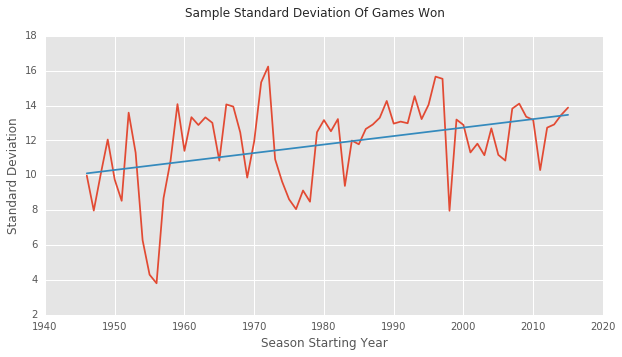

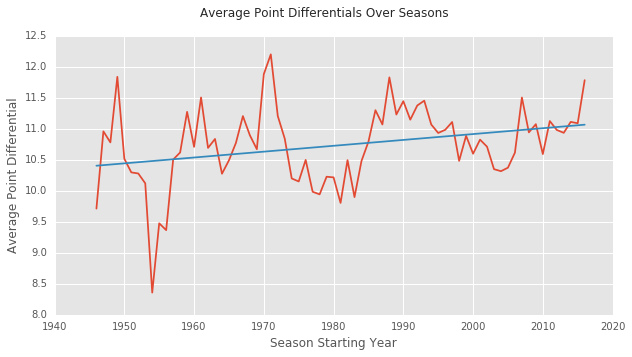

In [74]:
def get_team_wins_count(league_df, team_id, season_id):
    """ Given a df containing ALL game logs (including home and away), 
        team_id and season_id, returns number of wins the team got that season
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
        team_id (int or string): player ID number
        season_id (int or string): season ID number
    Output:
        (int): number of games team won in season
    """
    
    team_id = int(team_id)
    season_id = str(season_id)
    
    #print league_df['season_id'].dtype
    #print league_df['team_id'].dtype
    
    temp_df = league_df[(league_df['season_id'] == season_id) & (league_df['team_id'] == team_id)]
    
    temp_df = temp_df.sort_values('game_date')
    
    # get last game
    last_game = temp_df.iloc[len(temp_df) - 1]
    
    #print last_game
    #assert(last_game['home_game_count'] == 81 or last_game['away_game_count'] == 81)
    
    wins = 0
    games_won_so_far = 0
    if last_game['is_home']:
        games_won_so_far = int(round(last_game['home_win_pct']*last_game['home_game_count']))
    else:
        games_won_so_far = int(round(last_game['away_win_pct']*last_game['away_game_count']))
    wins = games_won_so_far + last_game['wl_binary']
    
    return wins
    
get_team_wins_count(all_games, "1610612742", "22004")

def graph_stdev_wins(league_df):
    """ Given a df containing ALL SORTED game logs (including home and away), 
        graphs stdev of team wins over time
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    stdevs = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        
        team_list = season_df['team_id'].unique().tolist()
        
        win_counts = []
        
        for team in team_list:
            team_wins = get_team_wins_count(league_df, team, season)
            win_counts.append(team_wins)
            
        stdev = np.array(win_counts).std(ddof = 1)
        #stdevs.append(season[1:], stdev)
        seasons.append(int(season[1:]))
        stdevs.append(stdev)
        
    # remove last, unfinished year
    seasons = seasons[:len(seasons)- 1]
    stdevs = stdevs[:len(stdevs) - 1]
    fig = plt.figure()
    fig.suptitle('Sample Standard Deviation Of Games Won',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Standard Deviation')
    plt.plot(seasons, stdevs, seasons, 
                  np.poly1d(np.polyfit(seasons, stdevs, 1))(np.unique(seasons)))
         
graph_stdev_wins(all_games)

def graph_avg_ptdiff(league_df):
    """ Given a df containing ALL SORTED game logs (including home and away), 
        graphs average (absolute value) ptdiff over seasons
    Input:
        league_df (pandas.DataFrame): dataframe containing post-processed league logs (both HOME and AWAY)
    Output:
        None
    """
    season_list = league_df['season_id'].unique().tolist()
    seasons = []
    avg_pt_diffs = []
    for season in season_list:
        season_df = league_df[league_df['season_id'] == season]
        pt_diff = season_df['plus_minus'].values
        pt_diff = np.apply_along_axis(lambda x: np.abs(x), 0, pt_diff)
        seasons.append(int(season[1:]))
        avg_pt_diffs.append(np.mean(pt_diff))
    fig = plt.figure()
    fig.suptitle('Average Point Differentials Over Seasons',fontsize=12)
    plt.xlabel('Season Starting Year')
    plt.ylabel('Average Point Differential')
    plt.plot(seasons, avg_pt_diffs, seasons, 
                  np.poly1d(np.polyfit(seasons, avg_pt_diffs, 1))(np.unique(seasons)))
        
#graph_avg_ptdiff(all_games)


def mean_ptdiff_top_bottom():
    pass
            
    
    